In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve, roc_auc_score

from xgboost import XGBClassifier

In [2]:
# Seed for random functions
SEED = 1

## Introduction

In [3]:
# Read in features
df_features = pd.read_csv('data/training_set_features.csv')
df_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
# Read in targets
df_targets = pd.read_csv('data/training_set_labels.csv')
df_targets.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


## Data Preparation: Common Preprocessing Tasks, EDA, and Data Splitting

### Range of Values and Data Types

In [5]:
# View unique values for each feature (except respondent id)
for c in list(df_features.columns)[1:]:
    print(f'feature: {c}')
    print(f'unique values: {list(df_features[c].unique())}')
    print('-------------')

feature: h1n1_concern
unique values: [1.0, 3.0, 2.0, 0.0, nan]
-------------
feature: h1n1_knowledge
unique values: [0.0, 2.0, 1.0, nan]
-------------
feature: behavioral_antiviral_meds
unique values: [0.0, 1.0, nan]
-------------
feature: behavioral_avoidance
unique values: [0.0, 1.0, nan]
-------------
feature: behavioral_face_mask
unique values: [0.0, 1.0, nan]
-------------
feature: behavioral_wash_hands
unique values: [0.0, 1.0, nan]
-------------
feature: behavioral_large_gatherings
unique values: [0.0, 1.0, nan]
-------------
feature: behavioral_outside_home
unique values: [1.0, 0.0, nan]
-------------
feature: behavioral_touch_face
unique values: [1.0, 0.0, nan]
-------------
feature: doctor_recc_h1n1
unique values: [0.0, nan, 1.0]
-------------
feature: doctor_recc_seasonal
unique values: [0.0, nan, 1.0]
-------------
feature: chronic_med_condition
unique values: [0.0, 1.0, nan]
-------------
feature: child_under_6_months
unique values: [0.0, 1.0, nan]
-------------
feature: h

In [6]:
# Check data types of columns
df_features.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

We can see from inspecting the values of the variables that all variables are, in fact, categorical. Certain categorical features are encoded numerically, but we will have to transform them to string type before using `DictVectorizer` to transform them into one-hot features.

### Clean String-Valued Columns

In [7]:
# Transform certain string columns to remove special characters
education_map = {'< 12 Years': 'Lt 12 Years'}
age_group_map = {'55 - 64 Years': '55 to 64', '35 - 44 Years': '35 to 44', '18 - 34 Years': '18 to 34', '65+ Years': '65 plus', '45 - 54 Years': '45 to 54'}
income_poverty_map = {'<= $75,000, Above Poverty': 'Above Poverty Lte 75k', '> $75,000': 'Above Poverty Gt 75k'}

df_features['education'] = df_features['education'].map(education_map).fillna(df_features['education'])
df_features['age_group'] = df_features['age_group'].map(age_group_map).fillna(df_features['age_group'])
df_features['income_poverty'] = df_features['income_poverty'].map(income_poverty_map).fillna(df_features['income_poverty'])

In [8]:
df_features[['education', 'age_group', 'income_poverty']].head()

,education,age_group,income_poverty
0,Lt 12 Years,55 to 64,Below Poverty
1,12 Years,35 to 44,Below Poverty
2,College Graduate,18 to 34,Above Poverty Lte 75k
3,12 Years,65 plus,Below Poverty
4,Some College,45 to 54,Above Poverty Lte 75k


In [9]:
# Standardize values for string columns
string_columns = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']
for c in string_columns:
    df_features[c] = df_features[c].str.lower().str.replace(',', '').str.replace(' ', '_')

In [10]:
df_features[string_columns].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
0,55_to_64,lt_12_years,white,female,below_poverty,not_married,own,not_in_labor_force,non-msa
1,35_to_44,12_years,white,male,below_poverty,not_married,rent,employed,msa_not_principle__city
2,18_to_34,college_graduate,white,male,above_poverty_lte_75k,not_married,own,employed,msa_not_principle__city
3,65_plus,12_years,white,female,below_poverty,not_married,rent,not_in_labor_force,msa_principle_city
4,45_to_54,some_college,white,female,above_poverty_lte_75k,married,own,employed,msa_not_principle__city


### Encode Float-Valued Variables as Strings

In [11]:
# Get all float-valued columns
float_columns = list(df_features.dtypes[df_features.dtypes == 'float64'].index)
float_columns

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [12]:
# Transform all float-valued columns to type string (except nan)
for c in float_columns:
    df_features[c] = df_features[c].astype(str)[df_features[c].notnull()]

In [13]:
# Check data types of columns
df_features.dtypes

respondent_id                   int64
h1n1_concern                   object
h1n1_knowledge                 object
behavioral_antiviral_meds      object
behavioral_avoidance           object
behavioral_face_mask           object
behavioral_wash_hands          object
behavioral_large_gatherings    object
behavioral_outside_home        object
behavioral_touch_face          object
doctor_recc_h1n1               object
doctor_recc_seasonal           object
chronic_med_condition          object
child_under_6_months           object
health_worker                  object
health_insurance               object
opinion_h1n1_vacc_effective    object
opinion_h1n1_risk              object
opinion_h1n1_sick_from_vacc    object
opinion_seas_vacc_effective    object
opinion_seas_risk              object
opinion_seas_sick_from_vacc    object
age_group                      object
education                      object
race                           object
sex                            object
income_pover

### Check for Missing Values

In [14]:
# Get columns with missing values
df_features.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [15]:
# Get columns where missing values represent more than 10% of the data
df_features.isna().mean()[df_features.isna().mean() > .1]

health_insurance         0.459580
income_poverty           0.165612
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

In [16]:
# Drop the columns with close to 50% data missing
df_features = df_features.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1)

In [17]:
df_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,white,female,below_poverty,not_married,own,not_in_labor_force,oxchjgsf,non-msa,0.0,0.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,white,male,below_poverty,not_married,rent,employed,bhuqouqj,msa_not_principle__city,0.0,0.0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,white,male,above_poverty_lte_75k,not_married,own,employed,qufhixun,msa_not_principle__city,2.0,0.0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,white,female,below_poverty,not_married,rent,not_in_labor_force,lrircsnp,msa_principle_city,0.0,0.0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,white,female,above_poverty_lte_75k,married,own,employed,qufhixun,msa_not_principle__city,1.0,0.0


### Split Data into Train and Test Sets

In [18]:
# Split the data into training and testing subsets (80-20 split)
features_train, features_test, targets_train, targets_test = train_test_split(df_features, df_targets, test_size=0.2, random_state=SEED)

features_train.shape, features_test.shape, targets_train.shape, targets_test.shape

((21365, 33), (5342, 33), (21365, 3), (5342, 3))

In [19]:
# Reset indices after shuffling
features_train = features_train.reset_index(drop=True).drop('respondent_id', axis=1)
features_test = features_test.reset_index(drop=True).drop('respondent_id', axis=1)
targets_train = targets_train.reset_index(drop=True).drop('respondent_id', axis=1)
targets_test = targets_test.reset_index(drop=True).drop('respondent_id', axis=1)

In [20]:
features_test

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,other_or_multiple,female,NaN,married,NaN,NaN,lzgpxyit,msa_not_principle__city,1.0,0.0
1,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,black,female,above_poverty_lte_75k,not_married,rent,employed,qufhixun,msa_principle_city,0.0,2.0
2,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,white,female,above_poverty_lte_75k,married,own,not_in_labor_force,mlyzmhmf,msa_not_principle__city,2.0,0.0
3,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,white,female,above_poverty_lte_75k,married,own,employed,bhuqouqj,msa_principle_city,1.0,0.0
4,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,black,female,NaN,NaN,NaN,NaN,qufhixun,msa_principle_city,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,black,female,above_poverty_lte_75k,married,own,employed,lzgpxyit,non-msa,1.0,0.0
5338,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,white,female,above_poverty_lte_75k,not_married,own,employed,lzgpxyit,non-msa,3.0,0.0
5339,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,white,female,above_poverty_lte_75k,married,rent,unemployed,mlyzmhmf,msa_principle_city,1.0,2.0
5340,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,white,female,above_poverty_lte_75k,married,rent,employed,kbazzjca,msa_principle_city,1.0,0.0


### Impute Missing Values with Mode Imputation

In [21]:
# Create SimpleImputer object for mode imputation
imputer = SimpleImputer(strategy='most_frequent')

# Impute all missing values in both training and testing feature dataframes
features_train = pd.DataFrame(imputer.fit_transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(imputer.transform(features_test), columns=features_test.columns)

### Analyze Target Variables

In [22]:
# Ensure there are no missing target values
pd.concat([targets_train, targets_test]).isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

In [23]:
# H1N1 vaccine label distribution (train)
targets_train['h1n1_vaccine'].value_counts(normalize=True)

h1n1_vaccine
0    0.786941
1    0.213059
Name: proportion, dtype: float64

In [24]:
# H1N1 vaccine label distribution (test)
targets_test['h1n1_vaccine'].value_counts(normalize=True)

h1n1_vaccine
0    0.789966
1    0.210034
Name: proportion, dtype: float64

In [25]:
# Seasonal flu vaccine label distribution (train)
targets_train['seasonal_vaccine'].value_counts(normalize=True)

seasonal_vaccine
0    0.531477
1    0.468523
Name: proportion, dtype: float64

In [26]:
# Seasonal flu vaccine label distribution (test)
targets_test['seasonal_vaccine'].value_counts(normalize=True)

seasonal_vaccine
0    0.54605
1    0.45395
Name: proportion, dtype: float64

The `seasonal_vaccine` variable is fairly balanced between positive and negative examples, but there is a fair amount of imbalance in the `h1n1_vaccine` variable. Thus, we will have to be careful with using a non-granular metric such as accuracy. We will be evaluating both models using area under the ROC curve (AUC). Except in cases of severe class imbalance, the ROC AUC is a balanced metric that takes both the true positive rate and false positive rate into account, and is therefore an informative metric in regard to both the majority and minority classes.

## Feature Importance, One-Hot Encoding, Model Training and Validation I: H1N1 Target

### Feature Importance Analysis: Mutual Information Between Features and H1N1 Target

In [27]:
# Define mutual information function to compute MI between any feature and the h1n1 target variable
def mutual_info_h1n1_score(series):
    return mutual_info_score(series, targets_train.h1n1_vaccine)

In [28]:
# Compute MI between each feature and the h1n1 target variable
mi_scores_h1n1 = features_train.apply(mutual_info_h1n1_score)

# Sort features in descending order of MI score
mi_scores_h1n1.sort_values(ascending=False)

doctor_recc_h1n1               0.066579
opinion_h1n1_risk              0.049233
opinion_h1n1_vacc_effective    0.044391
opinion_seas_risk              0.033016
doctor_recc_seasonal           0.022585
opinion_seas_vacc_effective    0.020832
health_worker                  0.012449
h1n1_concern                   0.007794
h1n1_knowledge                 0.007423
opinion_h1n1_sick_from_vacc    0.005004
chronic_med_condition          0.004472
behavioral_wash_hands          0.003181
behavioral_touch_face          0.002702
behavioral_face_mask           0.002343
child_under_6_months           0.001929
education                      0.001792
income_poverty                 0.001722
hhs_geo_region                 0.001695
age_group                      0.001416
race                           0.001146
opinion_seas_sick_from_vacc    0.001109
behavioral_avoidance           0.000903
behavioral_antiviral_meds      0.000767
marital_status                 0.000759
rent_or_own                    0.000455


### Feature Importance Analysis: Random Forest Feature Importances for Predicting H1N1 Target

In [29]:
# Initialize DictVectorizer for one-hot encoding categorical features
dv_h1n1 = DictVectorizer(sparse=False)

# Convert feature dataframes to a list of dictionaries, where each dictionary represents a row
dicts_train_h1n1 = features_train.to_dict(orient='records')
dicts_test_h1n1 = features_test.to_dict(orient='records')

# Fit the DictVectorizer on the training set features, and transform the training and test set features
X_train_h1n1 = dv_h1n1.fit_transform(dicts_train_h1n1)
X_test_h1n1 = dv_h1n1.transform(dicts_test_h1n1)

# Get NumPy arrays corresponding to training and test set targets
y_train_h1n1 = targets_train['h1n1_vaccine'].values
y_test_h1n1 = targets_test['h1n1_vaccine'].values

In [30]:
# Create small RandomForestClassifier model
rfc_h1n1 = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             random_state=SEED,
                             n_jobs=-1)

# Fit the classifier to the training data
rfc_h1n1.fit(X_train_h1n1, y_train_h1n1)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
# Sort the features in descending order of importance and print
importance_ordered_features_h1n1 = sorted(
    list(zip(list(dv_h1n1.get_feature_names_out()), rfc_h1n1.feature_importances_)),
    key=lambda x : x[1],
    reverse=True
)

importance_ordered_features_h1n1

[('doctor_recc_h1n1=0.0', 0.1362972402944536),
 ('doctor_recc_h1n1=1.0', 0.13476361876537685),
 ('opinion_h1n1_vacc_effective=5.0', 0.10686616565345042),
 ('doctor_recc_seasonal=1.0', 0.04418484743009949),
 ('health_worker=0.0', 0.03747901108287765),
 ('opinion_h1n1_risk=4.0', 0.034573690822891905),
 ('opinion_h1n1_risk=5.0', 0.02788037983857231),
 ('opinion_h1n1_risk=1.0', 0.027619988509431374),
 ('opinion_seas_vacc_effective=5.0', 0.022234593536741957),
 ('opinion_seas_risk=1.0', 0.02004642205597379),
 ('doctor_recc_seasonal=0.0', 0.01985942528254439),
 ('health_worker=1.0', 0.01457792355324701),
 ('opinion_seas_risk=5.0', 0.013802380349190829),
 ('opinion_h1n1_vacc_effective=4.0', 0.010116946086503523),
 ('opinion_seas_risk=2.0', 0.009402737933223684),
 ('opinion_h1n1_vacc_effective=3.0', 0.008377384998999374),
 ('opinion_h1n1_risk=2.0', 0.007773962405864465),
 ('opinion_seas_risk=4.0', 0.007308296899118765),
 ('opinion_seas_sick_from_vacc=1.0', 0.007015858599329778),
 ('h1n1_knowle

### Feature Selection

In [32]:
# Number of features after one-hot encoding
len(importance_ordered_features_h1n1)

107

In [33]:
# Number of original features corresponding to top k most important encoded features, according to RF model
# Here, we select all features since it seems to give a slight improvement over choosing a k, such as k=30
top_feats_h1n1 = set([x[0].split('=')[0] for x in importance_ordered_features_h1n1[:]])

len(top_feats_h1n1)

32

In [34]:
# Number of original features
len(features_train.columns)

32

In [35]:
# Original features corresponding to top k most important encoded features
top_feats_h1n1

{'age_group',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'behavioral_wash_hands',
 'census_msa',
 'child_under_6_months',
 'chronic_med_condition',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'education',
 'employment_status',
 'h1n1_concern',
 'h1n1_knowledge',
 'health_worker',
 'hhs_geo_region',
 'household_adults',
 'household_children',
 'income_poverty',
 'marital_status',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'race',
 'rent_or_own',
 'sex'}

In [36]:
# Most important features by mutual information score
mi_scores_h1n1.sort_values(ascending=False)

doctor_recc_h1n1               0.066579
opinion_h1n1_risk              0.049233
opinion_h1n1_vacc_effective    0.044391
opinion_seas_risk              0.033016
doctor_recc_seasonal           0.022585
opinion_seas_vacc_effective    0.020832
health_worker                  0.012449
h1n1_concern                   0.007794
h1n1_knowledge                 0.007423
opinion_h1n1_sick_from_vacc    0.005004
chronic_med_condition          0.004472
behavioral_wash_hands          0.003181
behavioral_touch_face          0.002702
behavioral_face_mask           0.002343
child_under_6_months           0.001929
education                      0.001792
income_poverty                 0.001722
hhs_geo_region                 0.001695
age_group                      0.001416
race                           0.001146
opinion_seas_sick_from_vacc    0.001109
behavioral_avoidance           0.000903
behavioral_antiviral_meds      0.000767
marital_status                 0.000759
rent_or_own                    0.000455


Although we presented two methods for feature importance analysis and feature selection, we choose to keep all features. This is because validation AUC was generally not improved by reducing the features, and in fact, retaining all features actually improved validation ROC for most models. However, the code above can be easily adjusted to select the top $k$ original (pre-one-hot encoding) features for training.

### Training Baseline Models

In [37]:
# Initialize DictVectorizer for one-hot encoding categorical features
dv_h1n1 = DictVectorizer(sparse=False)

# Convert feature dataframes (with subset of most important features) to a list of dictionaries, where each dictionary represents a row
dicts_train_h1n1 = features_train[list(top_feats_h1n1)].to_dict(orient='records')
dicts_test_h1n1 = features_test[list(top_feats_h1n1)].to_dict(orient='records')

# Fit the DictVectorizer on the training set features, and transform the training and test set features
X_train_h1n1 = dv_h1n1.fit_transform(dicts_train_h1n1)
X_test_h1n1 = dv_h1n1.transform(dicts_test_h1n1)

# Get NumPy arrays corresponding to training and test set targets
y_train_h1n1 = targets_train['h1n1_vaccine'].values
y_test_h1n1 = targets_test['h1n1_vaccine'].values

In [38]:
# Check how many features we have after one-hot encoding
X_train_h1n1.shape

(21365, 107)

In [39]:
# Initialize baseline LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier models
lr_h1n1 = LogisticRegression(solver='liblinear', random_state=SEED)
dtc_h1n1 = DecisionTreeClassifier(random_state=SEED)
rfc_h1n1 = RandomForestClassifier(n_jobs=-1, random_state=SEED)
xgbc_h1n1 = XGBClassifier(n_jobs=-1, random_state=SEED)

In [40]:
# Create the KFold object with n=5 splits 
kf_h1n1 = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Store cross validation results for each model
model_cv_results_h1n1 = {}

# Compute and store CV scores for LogisticRegression model
lr_cv_results_h1n1 = cross_val_score(lr_h1n1, X_train_h1n1, y_train_h1n1, cv=kf_h1n1, scoring='roc_auc')
model_cv_results_h1n1['logistic_regression'] = lr_cv_results_h1n1

# Compute and store CV scores for DecisionTreeClassifier model
dtc_cv_results_h1n1 = cross_val_score(dtc_h1n1, X_train_h1n1, y_train_h1n1, cv=kf_h1n1, scoring='roc_auc')
model_cv_results_h1n1['decision_tree_classifier'] = dtc_cv_results_h1n1

# Compute and store CV scores for LogisticRegression model
rfc_cv_results_h1n1 = cross_val_score(rfc_h1n1, X_train_h1n1, y_train_h1n1, cv=kf_h1n1, scoring='roc_auc')
model_cv_results_h1n1['random_forest_classifier'] = rfc_cv_results_h1n1

# Compute and store CV scores for LogisticRegression model
xgbc_cv_results_h1n1 = cross_val_score(xgbc_h1n1, X_train_h1n1, y_train_h1n1, cv=kf_h1n1, scoring='roc_auc')
model_cv_results_h1n1['xgboost_classifier'] = xgbc_cv_results_h1n1

In [41]:
# For each model, output the mean and standard deviation of the AUC across the n=5 folds
for model, res in model_cv_results_h1n1.items():
    print(f'model: {model}')
    print(f'\tavg auc: {res.mean().round(2)}')
    print(f'\tstd dev auc: {res.std().round(2)}')

model: logistic_regression
	avg auc: 0.83
	std dev auc: 0.01
model: decision_tree_classifier
	avg auc: 0.64
	std dev auc: 0.0
model: random_forest_classifier
	avg auc: 0.82
	std dev auc: 0.01
model: xgboost_classifier
	avg auc: 0.81
	std dev auc: 0.01


### Tuning Hyperparameters via Randomized Grid Search

In [42]:
# Initialize LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier models
lr_h1n1 = LogisticRegression(solver='liblinear', random_state=SEED)
dtc_h1n1 = DecisionTreeClassifier(random_state=SEED)
rfc_h1n1 = RandomForestClassifier(n_jobs=-1, random_state=SEED)
xgbc_h1n1 = XGBClassifier(random_state=SEED)

In [43]:
# Parameter grid to search over
params = {
    'penalty': ['l1', 'l2'],
    'tol': np.linspace(0.0001, 1.0, 50),
    'C': np.linspace(0.1, 1.0, 50),
    'class_weight': ['balanced', {0: 0.6, 1: 0.4}]
}

# Create the RandomizedSearchCV object
lr_cv_h1n1 = RandomizedSearchCV(lr_h1n1, params, cv=kf_h1n1, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
lr_cv_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Print the best parameters and AUC score we found
print("Tuned Logistic Regression Parameters: {}".format(lr_cv_h1n1.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(lr_cv_h1n1.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.12253673469387756, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.5591836734693878}
Tuned Logistic Regression Best Accuracy Score: 0.8302384503034863


In [44]:
# Parameter grid to search over
params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the RandomizedSearchCV object
dtc_cv_h1n1 = RandomizedSearchCV(dtc_h1n1, params, cv=kf_h1n1, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
dtc_cv_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Print the best parameters and AUC score we found
print("Tuned Decision Tree Classifier Parameters: {}".format(dtc_cv_h1n1.best_params_))
print("Tuned Decision Tree Classifier Best Accuracy Score: {}".format(dtc_cv_h1n1.best_score_))

Tuned Decision Tree Classifier Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10}
Tuned Decision Tree Classifier Best Accuracy Score: 0.7823638252976026


/home/lynnsamson/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [45]:
# Parameter grid to search over
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the RandomizedSearchCV object
rfc_cv_h1n1 = RandomizedSearchCV(rfc_h1n1, params, cv=kf_h1n1, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
rfc_cv_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Print the best parameters and AUC score we found
print("Tuned Random Forest Classifier Parameters: {}".format(rfc_cv_h1n1.best_params_))
print("Tuned Random Forest Classifier Best Accuracy Score: {}".format(rfc_cv_h1n1.best_score_))

/home/lynnsamson/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuned Random Forest Classifier Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 15}
Tuned Random Forest Classifier Best Accuracy Score: 0.8301040611078816


In [46]:
# Parameter grid to search over
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, 15],
    'eta': [0.05, 0.1],
    'grow_policy': ['depthwise', 'lossguide']
}

# Create the RandomizedSearchCV object
xgbc_cv_h1n1 = RandomizedSearchCV(xgbc_h1n1, params, cv=kf_h1n1, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
xgbc_cv_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Print the best parameters and AUC score we found
print("Tuned XGBoost Classifier Parameters: {}".format(xgbc_cv_h1n1.best_params_))
print("Tuned XGBoost Classifier Best Accuracy Score: {}".format(xgbc_cv_h1n1.best_score_))

Tuned XGBoost Classifier Parameters: {'n_estimators': 200, 'max_depth': 3, 'grow_policy': 'depthwise', 'eta': 0.1}
Tuned XGBoost Classifier Best Accuracy Score: 0.8327869456300843


## Feature Importance, One-Hot Encoding, Model Training and Validation I: Seasonal Flu Target

### Feature Importance Analysis: Mutual Information Between Features and Seasonal Flu Target

In [47]:
# Define mutual information function to compute MI between any feature and the seasonal flu target variable
def mutual_info_seasonal_score(series):
    return mutual_info_score(series, targets_train.seasonal_vaccine)

In [48]:
# Compute MI between each feature and the seasonal target variable
mi_scores_seasonal = features_train.apply(mutual_info_seasonal_score)

# Sort features in descending order of MI score
mi_scores_seasonal.sort_values(ascending=False)

opinion_seas_vacc_effective    0.082281
opinion_seas_risk              0.076900
doctor_recc_seasonal           0.065390
age_group                      0.042640
opinion_h1n1_risk              0.024541
opinion_h1n1_vacc_effective    0.023280
doctor_recc_h1n1               0.019188
chronic_med_condition          0.015033
employment_status              0.012884
h1n1_concern                   0.012714
health_worker                  0.008272
behavioral_touch_face          0.007300
household_children             0.007212
h1n1_knowledge                 0.007124
behavioral_wash_hands          0.006326
race                           0.005574
rent_or_own                    0.005437
opinion_seas_sick_from_vacc    0.003607
sex                            0.003113
income_poverty                 0.002772
behavioral_avoidance           0.002531
household_adults               0.002495
behavioral_large_gatherings    0.002224
education                      0.001965
behavioral_outside_home        0.001662


### Feature Importance Analysis: Random Forest Feature Importances for Predicting Seasonal Flu Target

In [49]:
# Initialize DictVectorizer for one-hot encoding categorical features
dv_seasonal = DictVectorizer(sparse=False)

# Convert feature dataframes to a list of dictionaries, where each dictionary represents a row
dicts_train_seasonal = features_train.to_dict(orient='records')
dicts_test_seasonal = features_test.to_dict(orient='records')

# Fit the DictVectorizer on the training set features, and transform the training and test set features
X_train_seasonal = dv_seasonal.fit_transform(dicts_train_seasonal)
X_test_seasonal = dv_seasonal.transform(dicts_test_seasonal)

# Get NumPy arrays corresponding to training and test set targets
y_train_seasonal = targets_train['seasonal_vaccine'].values
y_test_seasonal = targets_test['seasonal_vaccine'].values

In [50]:
# Create small RandomForestClassifier model
rfc_seasonal = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             random_state=SEED,
                             n_jobs=-1)

# Fit the classifier to the training data
rfc_seasonal.fit(X_train_seasonal, y_train_seasonal)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1, random_state=1)

In [51]:
# Sort the features in descending order of importance and print
importance_ordered_features_seasonal = sorted(
    list(zip(list(dv_seasonal.get_feature_names_out()), rfc_seasonal.feature_importances_)),
    key=lambda x : x[1],
    reverse=True
)

importance_ordered_features_seasonal

[('opinion_seas_vacc_effective=5.0', 0.18905491023457904),
 ('doctor_recc_seasonal=0.0', 0.11370025601769315),
 ('age_group=65_plus', 0.06496660356844955),
 ('opinion_seas_risk=1.0', 0.06172917340675734),
 ('doctor_recc_seasonal=1.0', 0.05837754278516882),
 ('opinion_seas_risk=4.0', 0.039903502362149755),
 ('opinion_seas_risk=5.0', 0.03711840565325274),
 ('age_group=18_to_34', 0.022537508133788034),
 ('opinion_seas_vacc_effective=2.0', 0.01906813189252593),
 ('health_worker=0.0', 0.018103794311850774),
 ('opinion_seas_vacc_effective=4.0', 0.01544589119394189),
 ('chronic_med_condition=0.0', 0.015306255499783367),
 ('opinion_seas_risk=2.0', 0.014826525625892253),
 ('opinion_h1n1_risk=4.0', 0.012823383016310636),
 ('employment_status=not_in_labor_force', 0.011067590075759831),
 ('h1n1_knowledge=2.0', 0.010922428287022718),
 ('doctor_recc_h1n1=0.0', 0.009787281067543074),
 ('rent_or_own=rent', 0.008724930206352389),
 ('race=white', 0.008517306338619688),
 ('opinion_h1n1_vacc_effective=5.0

### Feature Selection

In [52]:
# Number of features after one-hot encoding
len(importance_ordered_features_seasonal)

107

In [53]:
# Number of original features corresponding to top k most important encoded features, according to RF model
# Here, we select all features since it seems to give a slight improvement over choosing a k, such as k=30
top_feats_seasonal = set([x[0].split('=')[0] for x in importance_ordered_features_seasonal[:]])

len(top_feats_seasonal)

32

In [54]:
# Number of original features
len(features_train.columns)

32

In [55]:
# Original features corresponding to top k most important encoded features
top_feats_seasonal

{'age_group',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'behavioral_wash_hands',
 'census_msa',
 'child_under_6_months',
 'chronic_med_condition',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'education',
 'employment_status',
 'h1n1_concern',
 'h1n1_knowledge',
 'health_worker',
 'hhs_geo_region',
 'household_adults',
 'household_children',
 'income_poverty',
 'marital_status',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'race',
 'rent_or_own',
 'sex'}

In [56]:
# Most important features by mutual information score
mi_scores_seasonal.sort_values(ascending=False)

opinion_seas_vacc_effective    0.082281
opinion_seas_risk              0.076900
doctor_recc_seasonal           0.065390
age_group                      0.042640
opinion_h1n1_risk              0.024541
opinion_h1n1_vacc_effective    0.023280
doctor_recc_h1n1               0.019188
chronic_med_condition          0.015033
employment_status              0.012884
h1n1_concern                   0.012714
health_worker                  0.008272
behavioral_touch_face          0.007300
household_children             0.007212
h1n1_knowledge                 0.007124
behavioral_wash_hands          0.006326
race                           0.005574
rent_or_own                    0.005437
opinion_seas_sick_from_vacc    0.003607
sex                            0.003113
income_poverty                 0.002772
behavioral_avoidance           0.002531
household_adults               0.002495
behavioral_large_gatherings    0.002224
education                      0.001965
behavioral_outside_home        0.001662


Although we presented two methods for feature importance analysis and feature selection, we choose to keep all features. This is because validation AUC was generally not improved by reducing the features, and in fact, retaining all features actually improved validation ROC for most models. However, the code above can be easily adjusted to select the top $k$ original (pre-one-hot encoding) features for training.

### Training Baseline Models

In [57]:
# Initialize DictVectorizer for one-hot encoding categorical features
dv_seasonal = DictVectorizer(sparse=False)

# Convert feature dataframes (with subset of most important features) to a list of dictionaries, where each dictionary represents a row
dicts_train_seasonal = features_train[list(top_feats_seasonal)].to_dict(orient='records')
dicts_test_seasonal = features_test[list(top_feats_seasonal)].to_dict(orient='records')

# Fit the DictVectorizer on the training set features, and transform the training and test set features
X_train_seasonal = dv_seasonal.fit_transform(dicts_train_seasonal)
X_test_seasonal = dv_seasonal.transform(dicts_test_seasonal)

# Get NumPy arrays corresponding to training and test set targets
y_train_seasonal = targets_train['seasonal_vaccine'].values
y_test_seasonal = targets_test['seasonal_vaccine'].values

In [58]:
# Check how many features we have after one-hot encoding
X_train_seasonal.shape

(21365, 107)

In [59]:
# Initialize baseline LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier models
lr_seasonal = LogisticRegression(solver='liblinear', random_state=SEED)
dtc_seasonal = DecisionTreeClassifier(random_state=SEED)
rfc_seasonal = RandomForestClassifier(n_jobs=-1, random_state=SEED)
xgbc_seasonal = XGBClassifier(n_jobs=-1, random_state=SEED)

In [60]:
# Create the KFold object with n=5 splits 
kf_seasonal = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Store cross validation results for each model
model_cv_results_seasonal = {}

# Compute and store CV scores for LogisticRegression model
lr_cv_results_seasonal = cross_val_score(lr_seasonal, X_train_seasonal, y_train_seasonal, cv=kf_seasonal, scoring='roc_auc')
model_cv_results_seasonal['logistic_regression'] = lr_cv_results_seasonal

# Compute and store CV scores for DecisionTreeClassifier model
dtc_cv_results_seasonal = cross_val_score(dtc_seasonal, X_train_seasonal, y_train_seasonal, cv=kf_seasonal, scoring='roc_auc')
model_cv_results_seasonal['decision_tree_classifier'] = dtc_cv_results_seasonal

# Compute and store CV scores for LogisticRegression model
rfc_cv_results_seasonal = cross_val_score(rfc_seasonal, X_train_seasonal, y_train_seasonal, cv=kf_seasonal, scoring='roc_auc')
model_cv_results_seasonal['random_forest_classifier'] = rfc_cv_results_seasonal

# Compute and store CV scores for LogisticRegression model
xgbc_cv_results_seasonal = cross_val_score(xgbc_seasonal, X_train_seasonal, y_train_seasonal, cv=kf_seasonal, scoring='roc_auc')
model_cv_results_seasonal['xgboost_classifier'] = xgbc_cv_results_seasonal

In [61]:
# For each model, output the mean and standard deviation of the AUC across the n=5 folds
for model, res in model_cv_results_seasonal.items():
    print(f'model: {model}')
    print(f'\tavg auc: {res.mean().round(2)}')
    print(f'\tstd dev auc: {res.std().round(2)}')

model: logistic_regression
	avg auc: 0.85
	std dev auc: 0.0
model: decision_tree_classifier
	avg auc: 0.67
	std dev auc: 0.0
model: random_forest_classifier
	avg auc: 0.84
	std dev auc: 0.0
model: xgboost_classifier
	avg auc: 0.84
	std dev auc: 0.0


### Tuning Hyperparameters via Randomized Grid Search

In [62]:
# Initialize LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier models
lr_seasonal = LogisticRegression(solver='liblinear', random_state=SEED)
dtc_seasonal = DecisionTreeClassifier(random_state=SEED)
rfc_seasonal = RandomForestClassifier(n_jobs=-1, random_state=SEED)
xgbc_seasonal = XGBClassifier(random_state=SEED)

In [63]:
# Parameter grid to search over
params = {
    'penalty': ['l1', 'l2'],
    'tol': np.linspace(0.0001, 1.0, 50),
    'C': np.linspace(0.1, 1.0, 50),
    'class_weight': ['balanced', {0: 0.6, 1: 0.4}]
}

# Create the RandomizedSearchCV object
lr_cv_seasonal = RandomizedSearchCV(lr_seasonal, params, cv=kf_seasonal, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
lr_cv_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Print the best parameters and AUC score we found
print("Tuned Logistic Regression Parameters: {}".format(lr_cv_seasonal.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(lr_cv_seasonal.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.02050612244897959, 'penalty': 'l2', 'class_weight': {0: 0.6, 1: 0.4}, 'C': 0.7979591836734694}
Tuned Logistic Regression Best Accuracy Score: 0.8507180332752629


In [64]:
# Parameter grid to search over
params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the RandomizedSearchCV object
dtc_cv_seasonal = RandomizedSearchCV(dtc_seasonal, params, cv=kf_seasonal, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
dtc_cv_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Print the best parameters and AUC score we found
print("Tuned Decision Tree Classifier Parameters: {}".format(dtc_cv_seasonal.best_params_))
print("Tuned Decision Tree Classifier Best Accuracy Score: {}".format(dtc_cv_seasonal.best_score_))

Tuned Decision Tree Classifier Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10}
Tuned Decision Tree Classifier Best Accuracy Score: 0.7941736582969404


/home/lynnsamson/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [65]:
# Parameter grid to search over
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the RandomizedSearchCV object
rfc_cv_seasonal = RandomizedSearchCV(rfc_seasonal, params, cv=kf_seasonal, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
rfc_cv_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Print the best parameters and AUC score we found
print("Tuned Random Forest Classifier Parameters: {}".format(rfc_cv_seasonal.best_params_))
print("Tuned Random Forest Classifier Best Accuracy Score: {}".format(rfc_cv_seasonal.best_score_))

/home/lynnsamson/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuned Random Forest Classifier Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15}
Tuned Random Forest Classifier Best Accuracy Score: 0.849284337904052


In [66]:
# Parameter grid to search over
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, 15],
    'eta': [0.05, 0.1],
    'grow_policy': ['depthwise', 'lossguide']
}

# Create the RandomizedSearchCV object
xgbc_cv_seasonal = RandomizedSearchCV(xgbc_seasonal, params, cv=kf_seasonal, scoring='roc_auc', random_state=SEED)

# Perform randomized search over the parameter space
xgbc_cv_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Print the best parameters and AUC score we found
print("Tuned XGBoost Classifier Parameters: {}".format(xgbc_cv_seasonal.best_params_))
print("Tuned XGBoost Classifier Best Accuracy Score: {}".format(xgbc_cv_seasonal.best_score_))

Tuned XGBoost Classifier Parameters: {'n_estimators': 200, 'max_depth': 3, 'grow_policy': 'depthwise', 'eta': 0.1}
Tuned XGBoost Classifier Best Accuracy Score: 0.8540183994834518


## Selecting the Best Models for H1N1 and Seasonal Flu Targets, and Getting the Mean ROCAUC

For both the `h1n1_vaccine` and `seasonal_vaccine` prediction tasks, the XGBoost classifier performed the best, even if by a slight margin. Thus, we select the respective XGBoost classifier models we trained independently for each task, and take an unweighted mean of their AUC on the held-out test set as the final metric for the joint task of predicting whether any individual received the h1n1 or seasonal flu vaccines.

In [67]:
# Get the predicated probability scores on the test set
y_pred_h1n1 = xgbc_cv_h1n1.predict_proba(X_test_h1n1)[:, 1]
y_pred_seasonal = xgbc_cv_seasonal.predict_proba(X_test_seasonal)[:, 1]

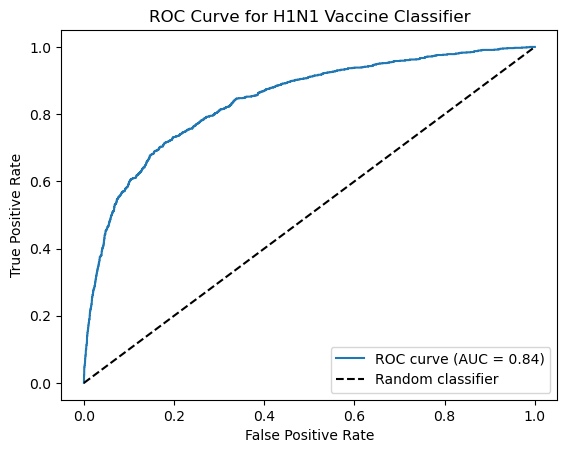

In [68]:
# Get the points on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_h1n1, y_pred_h1n1)

# Calculate the AUC
roc_auc = roc_auc_score(y_test_h1n1, y_pred_h1n1)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot the ROC curve of a uniform random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

# Labels and legends
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for H1N1 Vaccine Classifier')
plt.legend(loc='lower right')
plt.show()

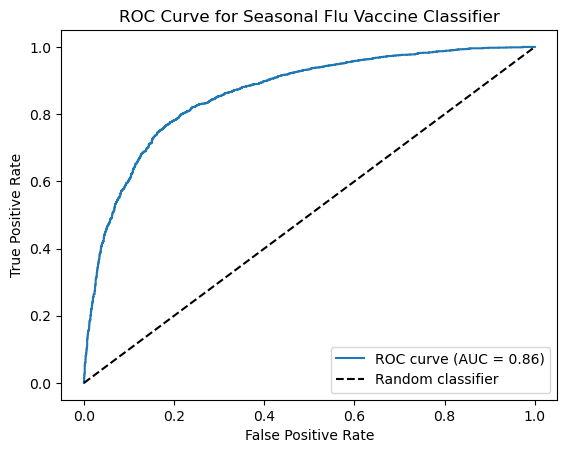

In [69]:
# Get the points on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_seasonal, y_pred_seasonal)

# Calculate the AUC
roc_auc = roc_auc_score(y_test_seasonal, y_pred_seasonal)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot the ROC curve of a uniform random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

# Labels and legends
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Seasonal Flu Vaccine Classifier')
plt.legend(loc='lower right')
plt.show()

In [70]:
# Place predicted probabilities for the h1n1 and seasonal flu targets into a DataFrame
pred_targets_test = pd.DataFrame(np.array([y_pred_h1n1, y_pred_seasonal]).T, columns=['h1n1_vaccine', 'seasonal_vaccine'])

# Compute the macro (unweighted average) AUC score
roc_auc_score(targets_test, pred_targets_test, average='macro')

0.8514708100521586